# Overview | Edge Detection

Link to the video: https://youtu.be/7AlwDYmjrcs

Edge detection - Convert a 2D image to a set of points where image intensity changes rapidly.

Topics:
1. What is an edge?
1. Edge detection using Gradients.
1. Edge detection using Laplacian.
1. Canny Edge detector.
1. Harris corner detection.

# What is an Edge?

Rapid change in image intensity withing small region.

We want Edge Operator that produce:
1. Edge position.
1. Edge magitude. (Strength)
1. Edge orientation. (Direction)

Perfomance Requirements:
1. High detection rate.
1. Good localization.
1. Low noise sensetiviti

# Edge Detection Using Gradients | Gradient Operator

Link to the video: https://youtu.be/lOEBsQodtEQ

## Basic gradient experiments

Basic calculus: **Derivative** of a continues function represents the amount of change in the function.

In [44]:
import numpy as np
from matplotlib import pyplot as plt

In [55]:
steps_zeros = np.zeros(5)
steps_ones = np.ones(5)
steps_zeros_2 = np.zeros(5)

steps = np.concatenate([steps_zeros, steps_ones, steps_zeros_2])

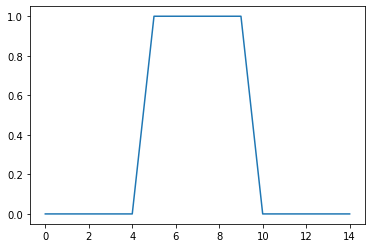

In [56]:
plt.plot(steps)

In [57]:
grad_steps = np.gradient(steps)

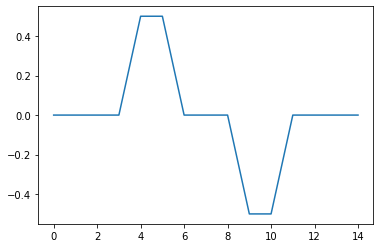

In [58]:
plt.plot(grad_steps)

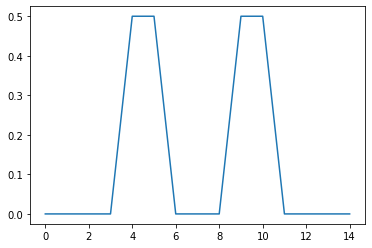

In [59]:
plt.plot(np.absolute(grad_steps))

## Sobel and Roberts filters to detect edges

Basic calculus: Partial Derivatives of a 2D continues function represents the amount of change along each dimension.

In [127]:
import torch
from torchvision import transforms

img2tensor = transforms.ToTensor()
img2grayscale = transforms.Grayscale()
def plot_tensor(t): 
    plt.figure(figsize=(10,10))
    plt.imshow(t.permute(1, 2, 0).detach().cpu())

from PIL import Image

eps = 1e-6

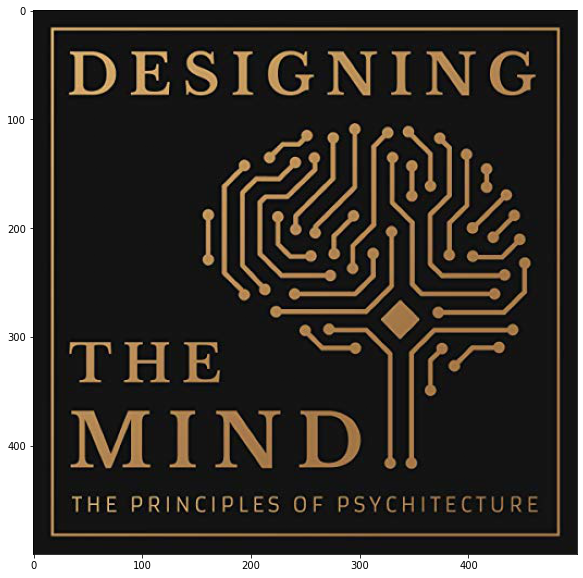

In [352]:
img = Image.open('assets/designing_the_mind.jpg')
img_t = img2tensor(img)
plot_tensor(img_t)

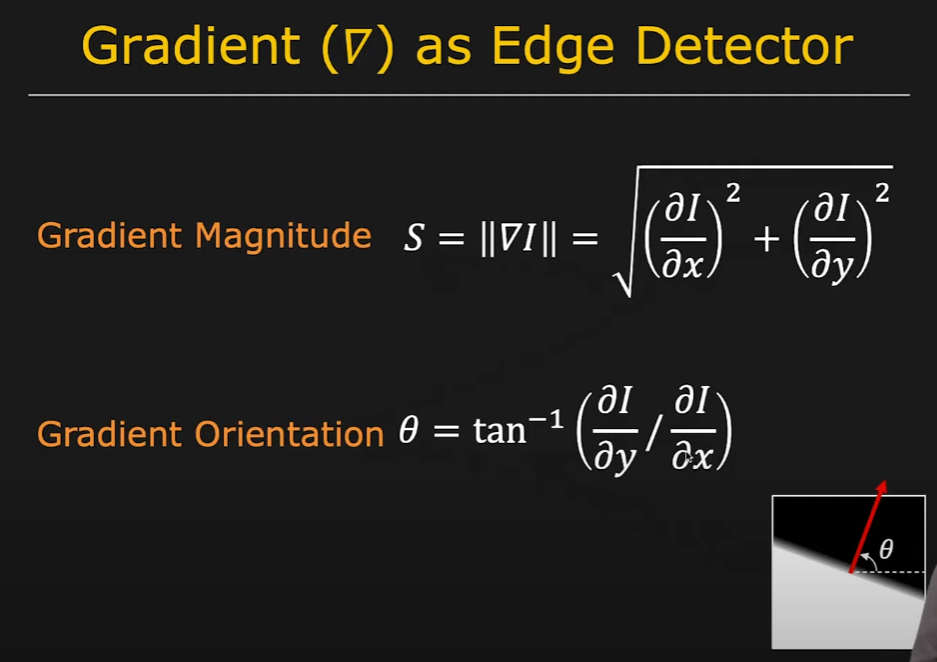

In [225]:
def first_order_grad(x):
    gray_img = img2grayscale(x).squeeze()
    np_img = gray_img.numpy()
    grads_xy = np.gradient(np_img)
    grads = np.sqrt(grads_xy[0]**2 + grads_xy[1]**2)
    
    return torch.tensor(grads).unsqueeze(0)

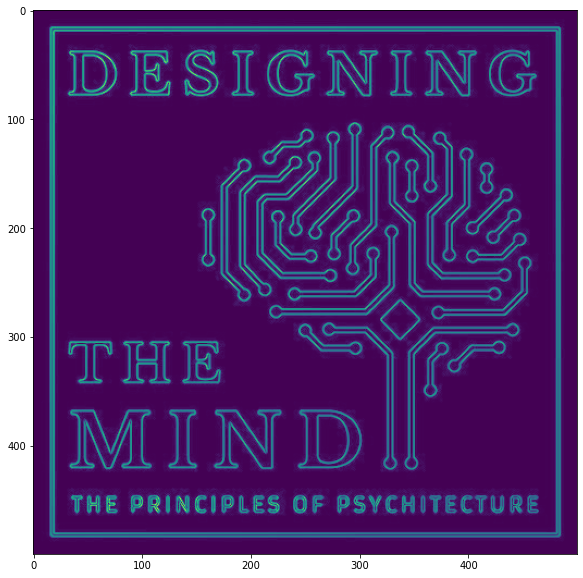

In [226]:
grads_img = first_order_grad(img_t)
plot_tensor(grads_img)

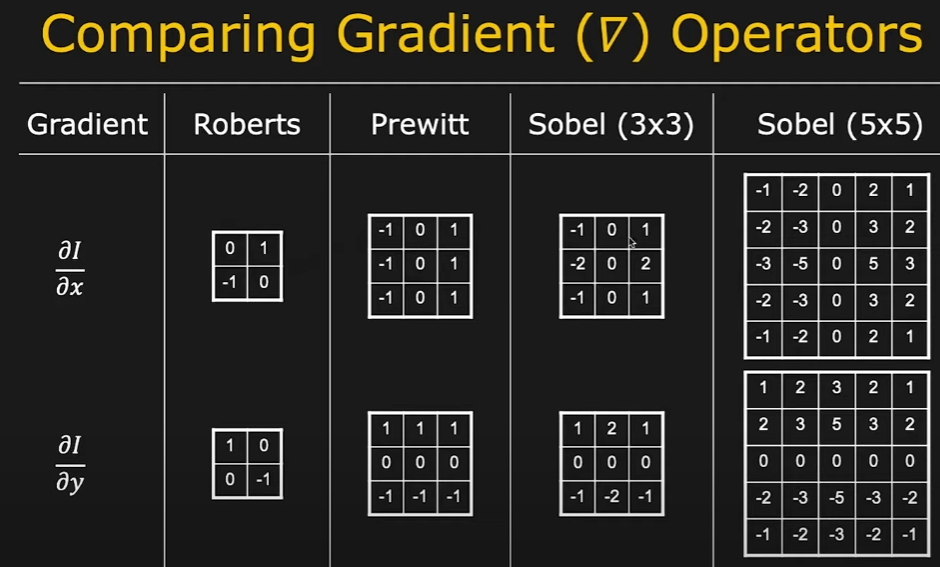

With different kernels you facing tradeoff between good edge localization and noise sensativity.

For example, to get an edge with roberts kernel, you only need 2 pixels. It's nice, but even small noise could be determined as edge.

With bigger kernel, like sobel 5x5 you have guasian smooth confidence, that you're looking on edge, but you lose localization power.

In [235]:
sobel_filter_x = torch.tensor([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]]).float().unsqueeze(0)

sobel_filter_y = torch.tensor([[1, 2, 1],
                                [0, 0, 0],
                                [-1, -2, -1]]).float().unsqueeze(0)

roberts_filter_x = torch.tensor([[0, 1, ],
                                 [-1, 0,]]).float().unsqueeze(0)
roberts_filter_y = torch.tensor([[1, 0, ],
                                 [0, -1,]]).float().unsqueeze(0)

sobel_filter = torch.cat([sobel_filter_x, sobel_filter_y]).unsqueeze(1)
roberts_filter = torch.cat([roberts_filter_x, roberts_filter_y]).unsqueeze(1)

def sobel_detection(x):
    gray_img = img2grayscale(x).unsqueeze(0)
    grads = torch.conv2d(gray_img, sobel_filter, stride=1, padding='same')[0]
    magnitude = torch.sqrt(grads[0]**2 + grads[1]**2)
    return magnitude.unsqueeze(0)

def roberts_detection(x):
    gray_img = img2grayscale(x).unsqueeze(0)
    grads = torch.conv2d(gray_img, roberts_filter, stride=1, padding=0)[0]
    magnitude = torch.sqrt(grads[0]**2 + grads[1]**2)
    return magnitude.unsqueeze(0)

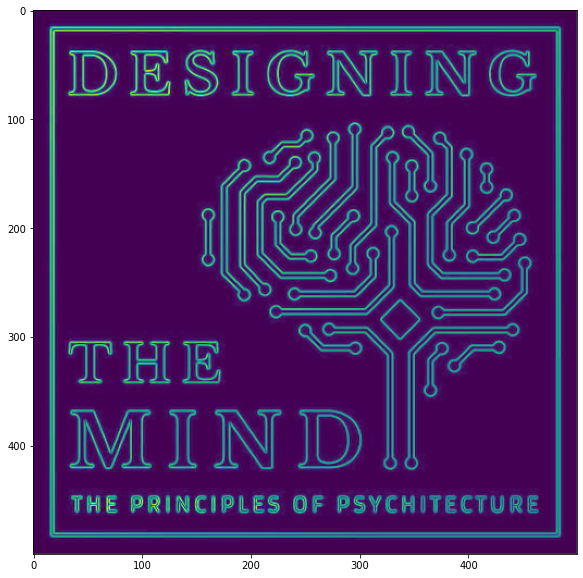

In [236]:
sobel_out = sobel_detection(img_t)
plot_tensor(sobel_out)

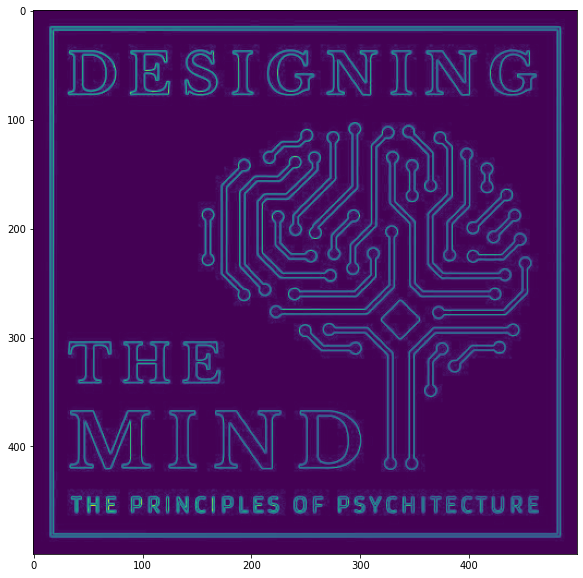

In [237]:
roberts_out = roberts_detection(img_t)
plot_tensor(roberts_out)

## Thresholding

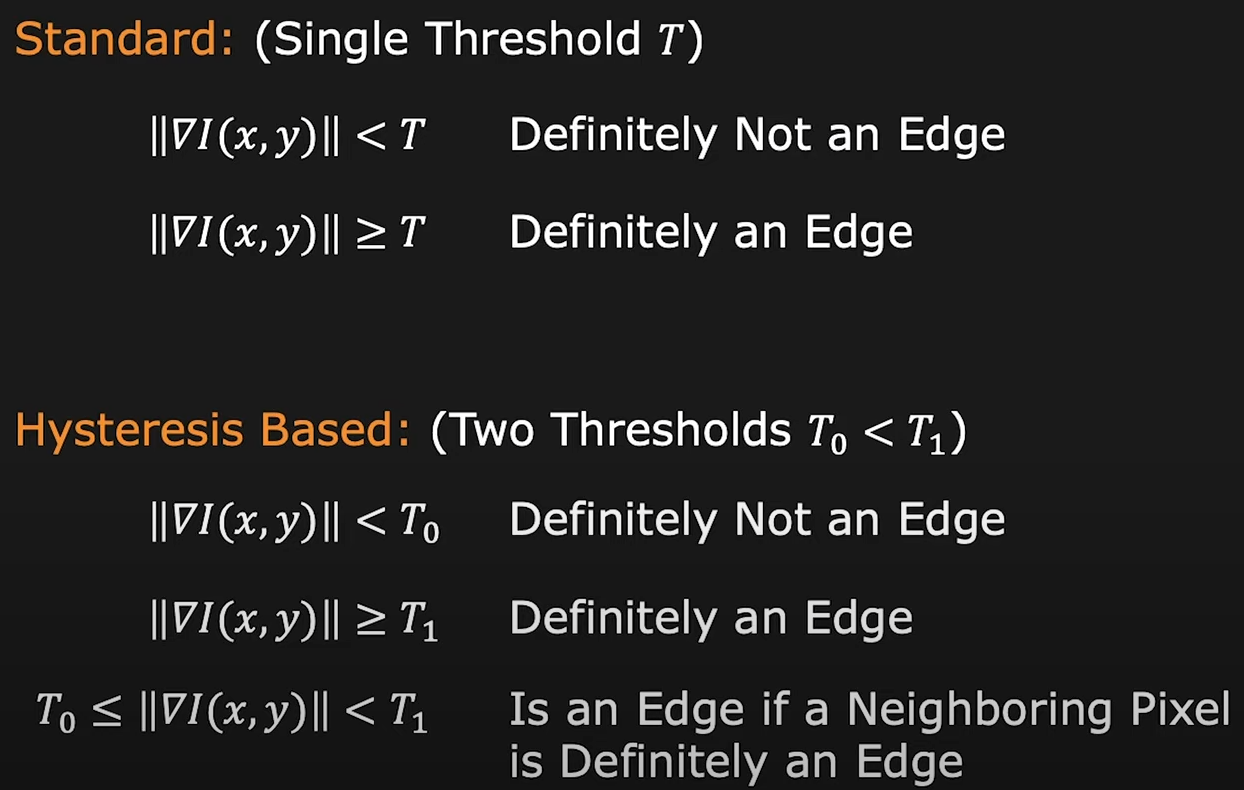

# Edge Detection Using Laplacian | Guasian + 2'nd Gradient

Link to the video: https://youtu.be/uNP6ZwQ3r6A

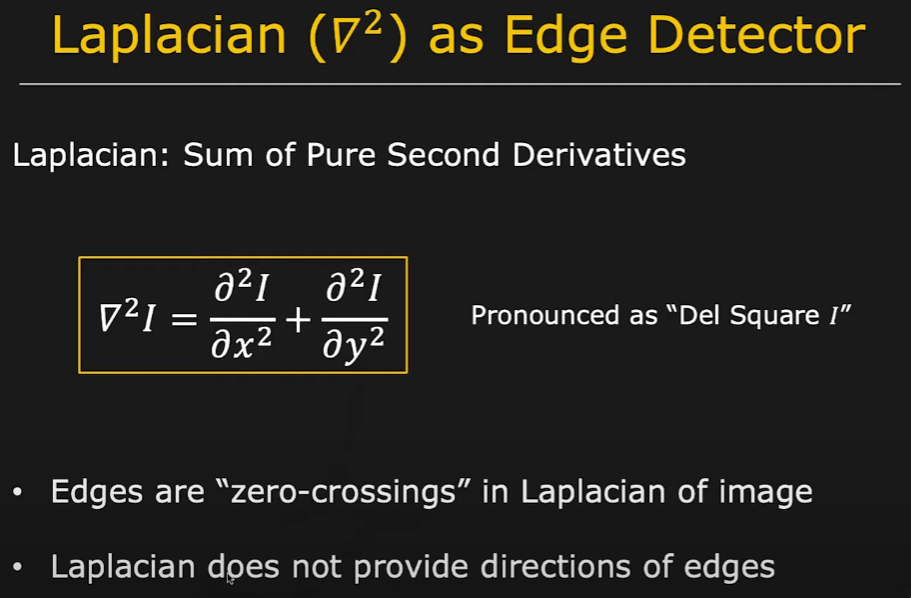

TODO: HOW TO GET ZERO-CROSSING?

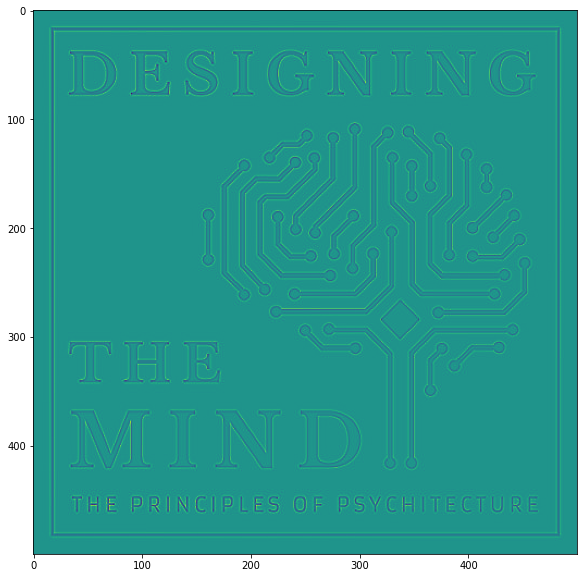

In [282]:
laplacian_filter = torch.tensor([[1,  4,  1],
                                 [4, -20, 4],
                                 [1,  4,  1]]).float().unsqueeze(0).unsqueeze(0)
# laplacian_filter = (1 / (6*(eps**2))) * laplacian_filter

def laplacian_detection(x):
    gray_img = img2grayscale(x).unsqueeze(0)
    grads = torch.conv2d(gray_img, laplacian_filter, stride=1, padding='same')
    # return torch.sqrt(grads[0]**2)
    return grads[0]

laplacian_out = laplacian_detection(img_t)
# laplacian_out[laplacian_out==0.]=1
# laplacian_out[laplacian_out<0.]=0
# laplacian_out[laplacian_out>0.]=1.
plot_tensor(laplacian_out)

In [263]:
laplacian_out.min(), laplacian_out.max()

(tensor(-8.4891), tensor(7.9375))

## Noise suppression | Laplacian Of Guassian Operator

We know that derivatives sensative to noise. And to reduce noise and preserve edges, we can apply guassian blur, to remove unnessesary noise and then apply detection.

We also know, that taking first order derivative is a linear operation. That give us possibility to make one operation instead of two:
We can get first order derivative of guassian, because it's linear.
And the same we can make with Laplacian: i.e. take second order derivative of guassian.

This is called **Laplacian Of Guassian Operator**

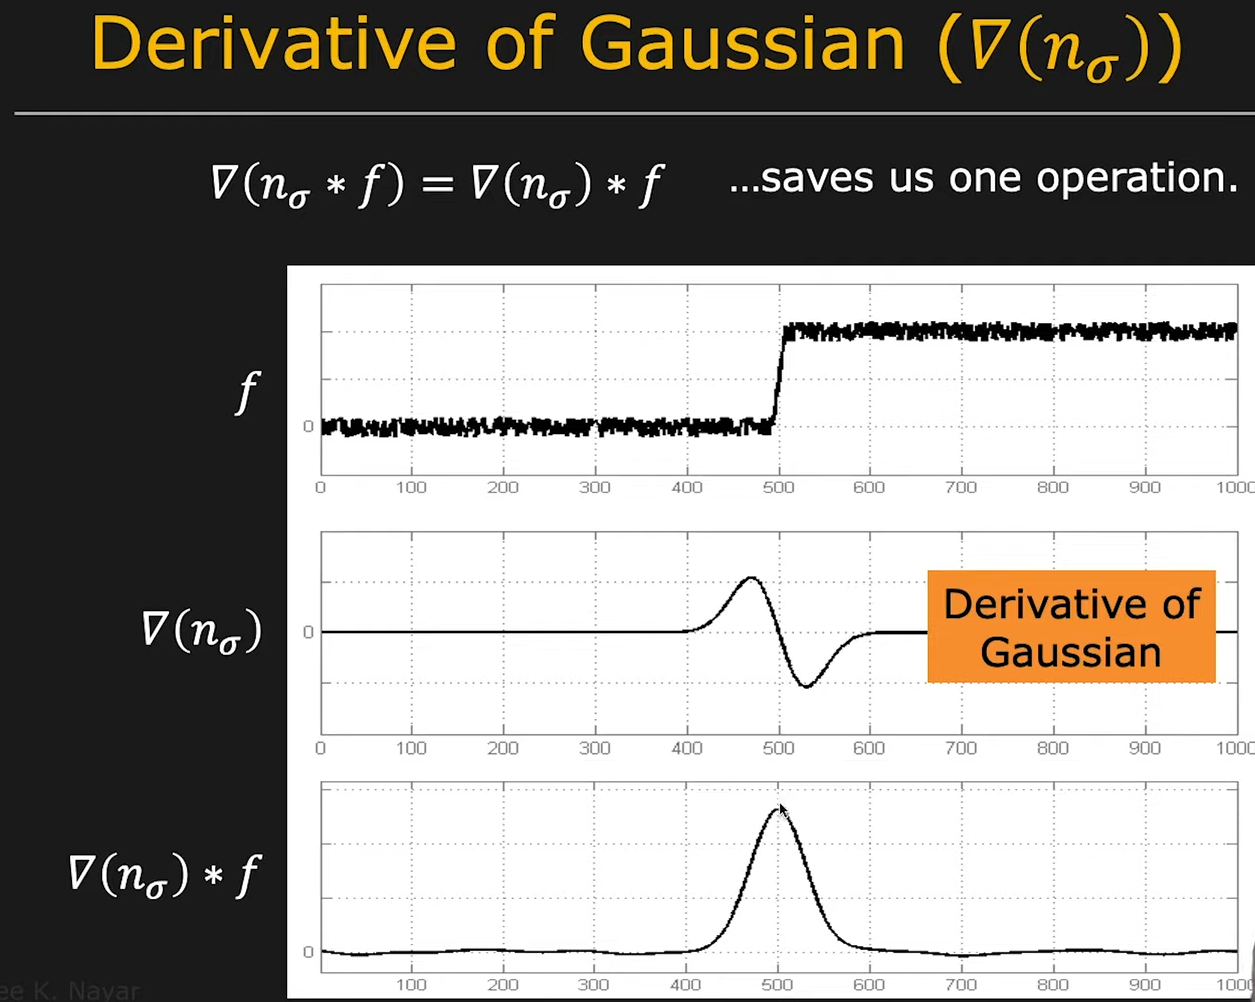

TODO: How two kernels merges? https://stackoverflow.com/questions/58357815/how-do-i-merge-2d-convolutions-in-pytorch

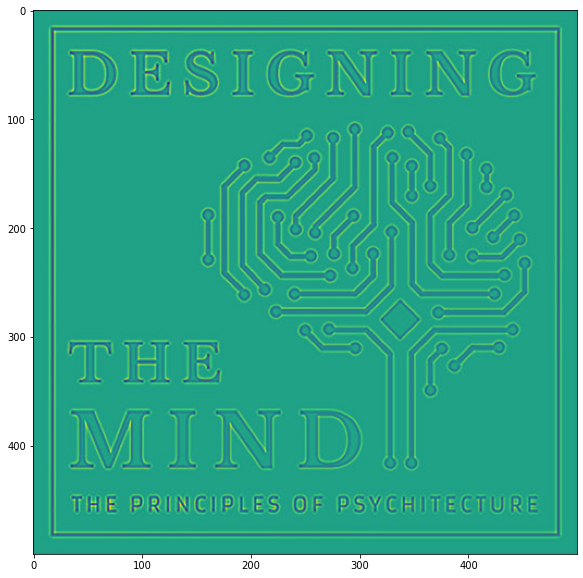

In [349]:
guassian_operator = torch.tensor([[1,  2,  1],
                                 [2, 4, 2],
                                 [1,  2,  1]]).float().unsqueeze(0).unsqueeze(0)
guassian_operator = (1 / 16) * guassian_operator

laplacian_filter = torch.tensor([[1,  4,  1],
                                 [4, -20, 4],
                                 [1,  4,  1]]).float().unsqueeze(0).unsqueeze(0)
# laplacian_filter = (1 / (6*(eps**2))) * laplacian_filter

log = torch.conv2d(guassian_operator, laplacian_filter, stride=1, padding=2)

def log_detection(x):
    gray_img = img2grayscale(x).unsqueeze(0)
    # grads = torch.conv2d(gray_img, log, stride=1, padding='same')
    grads = torch.conv2d(gray_img, log, stride=1, padding='same')
    return grads[0]

log_out = log_detection(img_t)
# log_out[log_out<0.]=0.
# log_out[log_out>0.]=1.
plot_tensor(log_out)

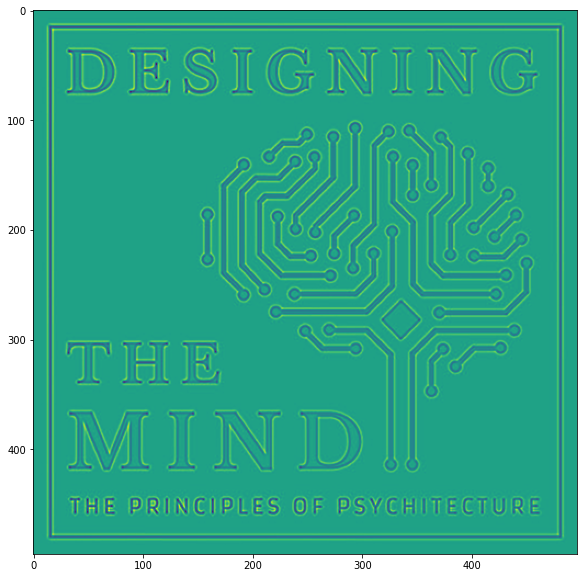

In [338]:
guassian_operator = torch.tensor([[1,  2,  1],
                                 [2, 4, 2],
                                 [1,  2,  1]]).float().unsqueeze(0).unsqueeze(0)
guassian_operator = (1 / 16) * guassian_operator

laplacian_filter = torch.tensor([[1,  4,  1],
                                 [4, -20, 4],
                                 [1,  4,  1]]).float().unsqueeze(0).unsqueeze(0)
# laplacian_filter = (1 / (6*(eps**2))) * laplacian_filter

def log_detection(x):
    gray_img = img2grayscale(x).unsqueeze(0)
    # guassed = torch.conv2d(gray_img, guassian_operator, stride=1, padding='same')
    guassed = torch.conv2d(gray_img, guassian_operator, stride=1, padding=0)
    grads = torch.conv2d(guassed, laplacian_filter, stride=1, padding=0)
    return grads[0]

log_out = log_detection(img_t)
# log_out[log_out<0.]=0.
# log_out[log_out>0.]=1.
plot_tensor(log_out)

## Gradient VS Laplacian

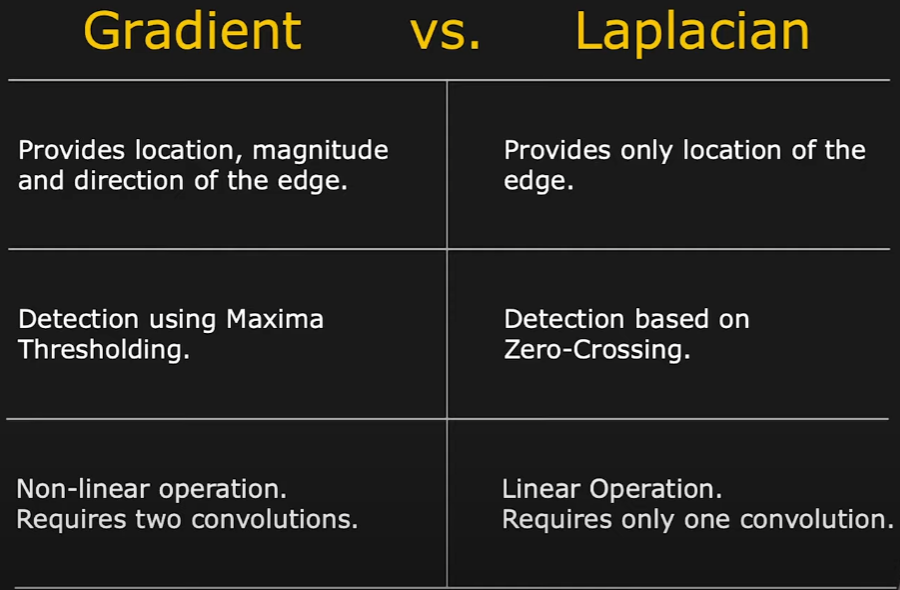

# Canny Edge Detector | TODO: finish the implementation

Link to the video: https://youtu.be/hUC1uoigH6s

Probably most popular edge detector in classic CV. It uses both advantages of gradient and laplacian detectors.

1. Smooth Image with 2D Guassian: $n_{\sigma}*I$
1. Compute Image gradient using Sobel operator: $\Delta n_{\sigma} * I$
1. Find gradient magnitude at each pixel: $|| \Delta n_{\sigma} * I ||$
1. Find gradient orientation at each pixel: $\hat{n} = \frac{\Delta n_{\sigma} * I}{|| \Delta n_{\sigma} * I ||}$
1. Compute Laplacian along the Gradient direction $\hat{n}$ at each pixel: $\frac{\delta^2(n_{\sigma} * I)}{\delta \hat{n}^2 }$
1. Find Zero Crossing in Laplacian to find the edges location.

Configuring $\sigma$ intensity, with big sigma small edges will be blured and more high level features be found.

Article that could be useful to implement it: https://towardsdatascience.com/implement-canny-edge-detection-from-scratch-with-pytorch-a1cccfa58bed

In [286]:
import torchvision

In [319]:
sobel_filter_x = torch.tensor([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]]).float().unsqueeze(0)

sobel_filter_y = torch.tensor([[1, 2, 1],
                                [0, 0, 0],
                                [-1, -2, -1]]).float().unsqueeze(0)

sobel_filter = torch.cat([sobel_filter_x, sobel_filter_y]).unsqueeze(1)

kernel_size = 3.
sigma = (0.01, 0.01)

x = img_t.unsqueeze(0)
x = img2grayscale(x)
guassian_f = torchvision.transforms.GaussianBlur(kernel_size, sigma=sigma)
x = guassian_f(x)
grads = torch.conv2d(x, sobel_filter, stride=1, padding='same')[0]
magnitude = torch.sqrt(grads[0]**2 + grads[1]**2)
orientation = (grads[0] + grads[1]) / magnitude

lap_over_orientation = torch.conv2d(orientation.unsqueeze(0).unsqueeze(0), log, stride=1, padding='same')

In [329]:
torch.isclose(lap_over_orientation, torch.zeros_like(lap_over_orientation)).sum()

tensor(0)

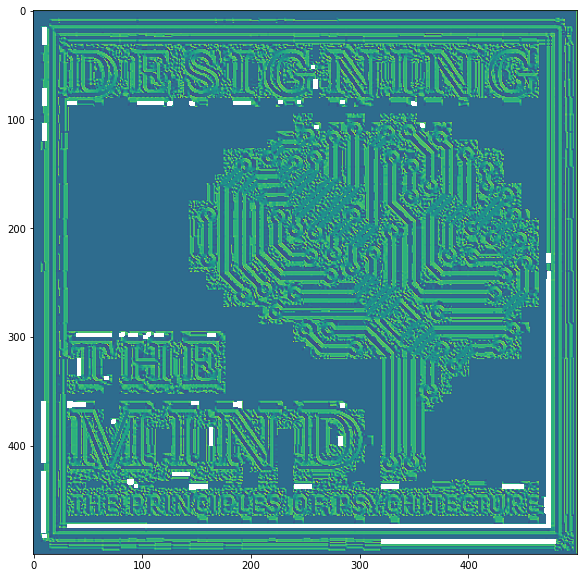

In [332]:
plot_tensor(lap_over_orientation.squeeze(0))